In [3]:
import pickle
import sys
import os
sys.path.append("..")
from copy import deepcopy

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd

import matplotlib.pyplot as plt
from torchmetrics import MeanSquaredError

In [4]:
from hpl.utils.postprocessing import (
    find_experiments_directories,
    load_data_assimilation_network,
    load_hydra_config,
    dictconfig_to_dataframe,
    reconstruct_observations,
)
from hpl.datamodule.DataLoader import L96InferenceDataset
from hpl.datamodule.observational_models import RandomObservationModel
from hpl.scripts.test_data_assimilation_encoder import mesh_test_single_model

In [5]:
base_dir = "/gpfs/work/zinchenk/final_experiments/30042024_input_window"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [7]:
hyda_experiments = find_experiments_directories([base_dir])

In [8]:
def main(hydra_experiment: str, device: str):
    assimilation_network = load_data_assimilation_network(hydra_experiment, device=device)
    config = load_hydra_config(hydra_experiment)
    results_frame = dictconfig_to_dataframe(config)
    results_frame.insert(0, "experiment_dir", hydra_experiment, False)

    torch.manual_seed(random_seed)
    pl.seed_everything(random_seed)

    observational_model = RandomObservationModel(
        additional_noise_std=config.datamodule.observation_model.additional_noise_std,
        random_mask_fraction=config.datamodule.observation_model.random_mask_fraction,
    )
    dataset = L96InferenceDataset(
        ground_truth_data=test_simulations,
        observation_model=observational_model,
        input_window_extend=config.input_window_extend,
        drop_edge_samples=True,
    )

    reconstructions = reconstruct_observations(dataset, assimilation_network)
    ground_truth = dataset.ground_truth[:, config.input_window_extend:-config.input_window_extend+1]
    squered_errors = (reconstructions - ground_truth)**2
    rmse_per_test_case = squered_errors.mean((-1, -2)).sqrt()

    results_frame.insert(0, "min_rmse", rmse_per_test_case.min().cpu().item(), False)
    results_frame.insert(0, "max_rmse", rmse_per_test_case.max().cpu().item(), False)
    results_frame.insert(0, "mean_rmse", rmse_per_test_case.mean().cpu().item(), False)
    results_frame.insert(0, "std_rmse", rmse_per_test_case.std().cpu().item(), False)

    return results_frame

In [9]:
results = []
for experiment in tqdm(hyda_experiments):
    res = main(experiment, device)
    results.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [34:16<00:00, 27.42s/it]


In [10]:
df = pd.concat(results, ignore_index=True)
df.to_pickle("30042024_input_window")

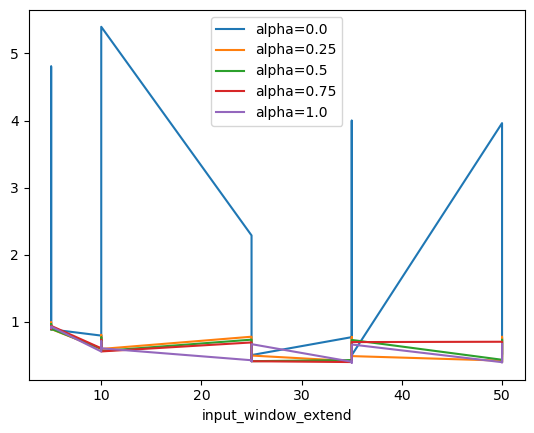

In [11]:



for alpha in sorted(df.loss_alpha.unique()):
    df[df.loss_alpha == alpha].sort_values("input_window_extend").plot(x="input_window_extend", y="mean_rmse", ax=ax, label=f"alpha={alpha}")

# ax.set_ylable("RMSE")

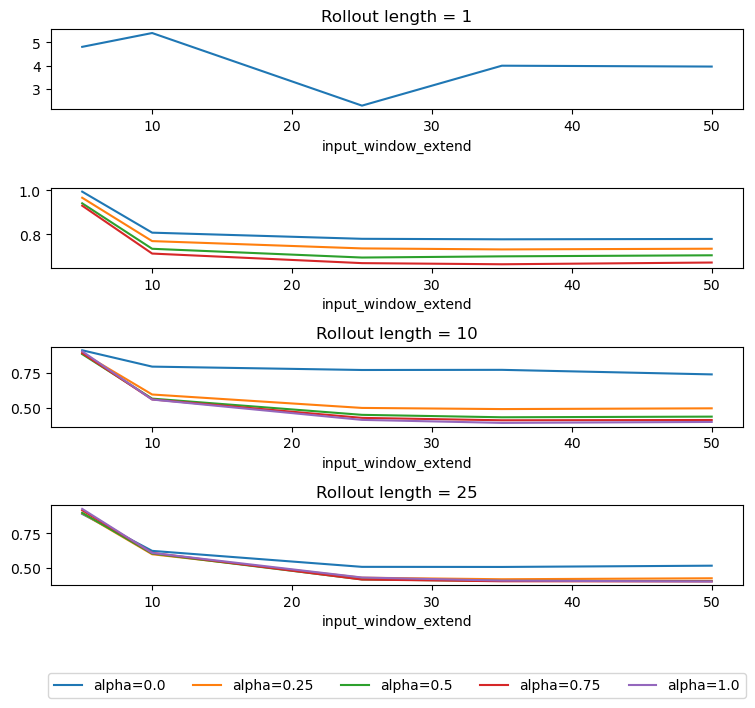

In [61]:
mosaic = """
aa
bb
cc
dd
"""
fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8))

df_tmp = df[df.rollout_length == 1]
for alpha in sorted(df_tmp.loss_alpha.unique()):
    if alpha > 0:
        df_tmp[df_tmp.loss_alpha == alpha].sort_values("input_window_extend").plot(x="input_window_extend", y="mean_rmse", ax=axd["b"], label=f"alpha={alpha}", legend=False)
    else:
        df_tmp[df_tmp.loss_alpha == alpha].sort_values("input_window_extend").plot(x="input_window_extend", y="mean_rmse", ax=axd["a"], label=f"alpha={alpha}", legend=False)

df_tmp = df[df.rollout_length == 10]
for alpha in sorted(df_tmp.loss_alpha.unique()):
    df_tmp[df_tmp.loss_alpha == alpha].sort_values("input_window_extend").plot(x="input_window_extend", y="mean_rmse", ax=axd["c"], label=f"alpha={alpha}", legend=False)

df_tmp = df[df.rollout_length == 25]
for alpha in sorted(df_tmp.loss_alpha.unique()):
    df_tmp[df_tmp.loss_alpha == alpha].sort_values("input_window_extend").plot(x="input_window_extend", y="mean_rmse", ax=axd["d"], label=f"alpha={alpha}", legend=False)

axd["a"].set_title("Rollout length = 1")
axd["c"].set_title("Rollout length = 10")
axd["d"].set_title("Rollout length = 25")

handles, labels = axd["d"].get_legend_handles_labels()
# fig.legend()
axd["d"].legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -1.5))

plt.tight_layout()
plt.savefig("different_input_window.png", dpi=300)

[1, 10, 25]